In [3]:
import json
import shutil
import itertools
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
import hdbscan
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import Dropdown, VBox, interactive
from IPython.display import display
from pydpc import Cluster as DPCClustering

In [4]:
df = pd.read_csv("features-bulk.csv")
df

,space_group,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state,density,vpa,packing fraction
0,124,14.0,41.0,27.0,34.166667,9.111111,41.0,47.0,78.0,31.0,...,222.833333,9.611111,229.0,0,0,0,0.000000,7.834556,16.201654,0.688834
1,164,13.0,27.0,14.0,19.000000,6.400000,14.0,58.0,78.0,20.0,...,213.400000,15.520000,194.0,-4,3,7,3.872983,5.384968,12.397466,0.644386
2,221,14.0,76.0,62.0,45.000000,31.000000,14.0,57.0,78.0,21.0,...,210.500000,16.500000,194.0,-4,4,8,5.656854,13.968635,12.976265,0.569426
3,63,31.0,31.0,0.0,31.000000,0.000000,31.0,74.0,74.0,0.0,...,64.000000,0.000000,64.0,0,0,0,0.000000,6.036267,19.180359,0.479802
4,62,14.0,44.0,30.0,34.000000,13.333333,44.0,56.0,78.0,22.0,...,205.000000,14.666667,194.0,-4,2,6,4.242641,9.539514,13.358418,0.598395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,194,6.0,48.0,42.0,24.500000,11.750000,22.0,43.0,77.0,34.0,...,194.000000,0.000000,194.0,0,0,0,0.000000,6.016734,15.190017,0.658712
1177,63,14.0,21.0,7.0,17.500000,3.500000,14.0,11.0,78.0,67.0,...,210.500000,16.500000,194.0,0,0,0,0.000000,3.336856,18.174013,0.625414
1178,63,14.0,39.0,25.0,26.500000,12.500000,14.0,12.0,78.0,66.0,...,210.500000,16.500000,194.0,0,0,0,0.000000,4.462773,21.765469,0.689264
1179,140,13.0,29.0,16.0,18.333333,7.111111,13.0,64.0,73.0,9.0,...,225.000000,0.000000,225.0,0,0,0,0.000000,4.356814,14.928982,0.595452


In [5]:
df1 = df.copy()

In [6]:
df2 = df1.copy()

In [7]:
data = df1.values
col_stds = data.std(axis=0)  # shape: (n_features,)
zero_std_mask = (col_stds == 0)

# If there are zero-variance columns, print their indices
if np.any(zero_std_mask):
    zero_cols = np.where(zero_std_mask)[0]
    print("These columns are constant and will not be used for clustering/PCA:", zero_cols)

# Remove these columns (keep columns where std is not zero)
data_nonzero = data[:, ~zero_std_mask]
print("Shape after removing zero-variance columns:", data_nonzero.shape)

# -------------------------------------------------------------------
# 3. Standardization (StandardScaler)
# -------------------------------------------------------------------
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_nonzero)
print("Shape after standardization:", data_normalized.shape)


These columns are constant and will not be used for clustering/PCA: [ 97  98  99 100 101 102]
Shape after removing zero-variance columns: (1181, 134)
Shape after standardization: (1181, 134)


# HDBSCAN

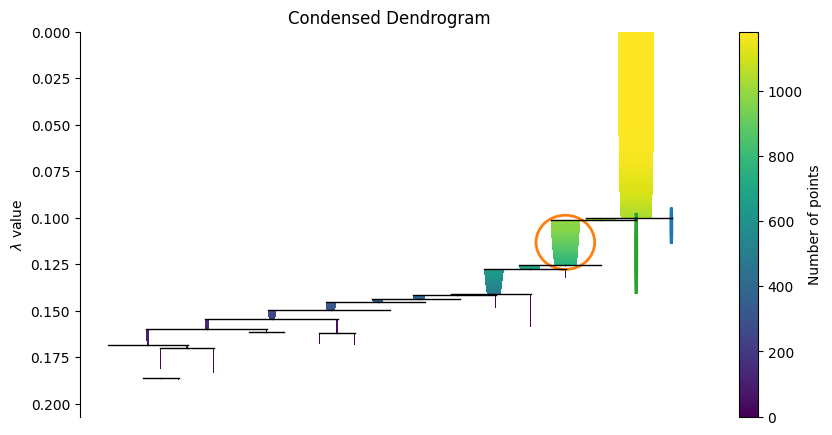

The algorithm finds 3 clusters.
Outliers: 158 samples
Cluster 0: 17 samples
Cluster 1: 984 samples
Cluster 2: 22 samples


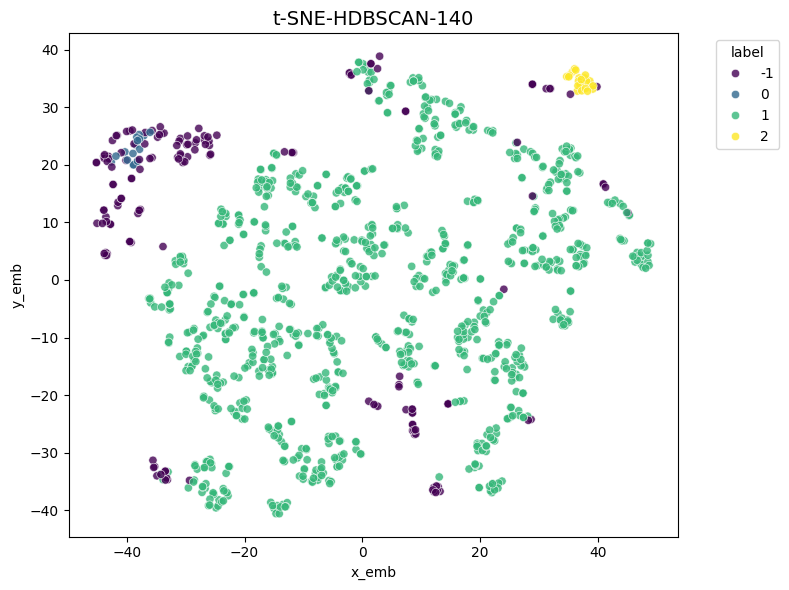

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=11, metric='euclidean')
clusterer.fit(data_normalized)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title('Condensed Dendrogram')
plt.show()
# 输出聚类结果
print(f"The algorithm finds {str(clusterer.labels_.max() + 1)} clusters.")

cluster_labels = clusterer.labels_
# 将聚类标签加入原始数据
df1["cluster_label"] = cluster_labels

# 统计每个簇（包括离群点）的个数
cluster_counts = df1["cluster_label"].value_counts().sort_index()

# 输出每个簇的样本数量
for cluster_label, count in cluster_counts.items():
    cluster_name = "Outliers" if cluster_label == -1 else f"Cluster {cluster_label}"
    print(f"{cluster_name}: {count} samples")

from sklearn.manifold import TSNE

embedding = TSNE(n_components=2).fit_transform(data_normalized)

df1["x_emb"] = embedding[:, 0]
df1["y_emb"] = embedding[:, 1]

# 1. 用 Seaborn 绘制散点图，可视化聚类
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df1,
    x="x_emb",
    y="y_emb",
    hue="cluster_label",  # 这里按照你聚类的标签着色
    palette="viridis",    # 指定调色板(可换成你喜欢的颜色方案)
    alpha=0.8             # 设置点透明度
)

# 2. 给图添加标题
plt.title("t-SNE-HDBSCAN-140", fontsize=14)
plt.legend(title="label", bbox_to_anchor=(1.05, 1), loc="upper left")

# 3. 显示图像
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# 1. 计算 t-SNE 嵌入
embedding = TSNE(n_components=2, random_state=42).fit_transform(data_normalized)

# 2. 将 t-SNE 结果添加到 DataFrame
df1["x_emb"] = embedding[:, 0]
df1["y_emb"] = embedding[:, 1]

# 强制将 Cluster_label 转换为字符串，以确保使用离散颜色
df1["cluster_label"] = df1["cluster_label"].astype(str)

# 3. 使用 Plotly 实现交互式可视化
def plot_interactive(df, color_feature, hover_features=["space_group", "density"]):
    """
    Function to create an interactive scatter plot.
    
    Parameters:
    - df: DataFrame with t-SNE results and clustering/space_group/density labels.
    - color_feature: Feature name to use as color coding (e.g., Cluster_label, space_group, density).
    - hover_features: List of column names to include in hover info.
    """
    # 强制分类特征使用离散调色板
    is_discrete = df[color_feature].dtype == 'object'

    fig = px.scatter(
        df,
        x="x_emb",
        y="y_emb",
        color=color_feature,
        title=f"t-SNE Visualization: {color_feature}",
        labels={"x_emb": "t-SNE Dim 1", "y_emb": "t-SNE Dim 2"},
        color_discrete_sequence=px.colors.qualitative.Vivid if is_discrete else None,
        color_continuous_scale="Viridis" if not is_discrete else None,
        opacity=0.8,
        hover_data=hover_features  # Add specified hover info
    )
    fig.update_layout(
        legend_title=dict(text=color_feature),
        legend=dict(orientation="v", x=1.02, y=1, bgcolor="rgba(255,255,255,0.5)"),
        margin=dict(l=50, r=10, t=50, b=10),
        width=1000,  # 图的宽度（单位：像素）
        height=600   # 图的高度（单位：像素）
    )
    fig.show()

# 4. 初始可视化（按 Cluster_label 着色，强制使用分类颜色）
plot_interactive(df1, "cluster_label")

# 5. 可切换到按 space_group 着色
plot_interactive(df1, "space_group")

# 6. 可切换到按 density 着色（梯度颜色）
plot_interactive(df1, "density")


/Users/meiyan/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:1992: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


# DPC

In [10]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pydpc import Cluster as DPCClustering
np.bool = bool
class MyClustering:
    def __init__(self, df, pca_array):
        """
        df:         你的 DataFrame，行数需与 pca_array 对应
        pca_array:  形如 (n_samples, 20) 的 PCA 结果数组，
                    即你想用来做聚类的特征数据
        """
        self.df = df
        self.pca_array = pca_array  # 直接存数组
        self.df_flag = False        # 用来控制是否跳过聚类逻辑（可随意）
    
    def dpc(self, density=0, delta=0):
        """
        如果 density、delta 都 > 0，则根据这两个值调用 assign()，
        否则仅初始化 DPCClustering，但不执行聚类。
        最后把标签写进 self.df['cluster_label']。
        增加异常值处理逻辑：基于密度计算异常值，并标记为 -1。
        """
        # 如果 df_flag 为 True，就什么都不做
        if self.df_flag:
            return
        
        # 1. 取出 PCA 的数组，用于聚类
        X = np.ascontiguousarray(self.pca_array)
        
        # 2. 判断 density、delta
        if density > 0 and delta > 0:
            # 正式执行 DPCClustering
            clu = DPCClustering(X, autoplot=False)
            clu.autoplot = True
            
            # assign(density, delta) 进行聚类
            clu.assign(density, delta)
            
            # 获取聚类标签
            cluster_labels = clu.membership
            
            # 获取每个点的密度
            densities = clu.density
            
            # 计算密度的第 5 个百分位数作为阈值
            density_threshold = np.percentile(densities, 5)
            print(f"Density threshold for outliers: {density_threshold}")
            
            # 找到密度低于阈值的点，标记为异常值（-1）
            outlier_indices = densities < density_threshold
            cluster_labels_adjusted = cluster_labels.copy()
            cluster_labels_adjusted[outlier_indices] = -1
            
            # 输出聚类数（不包括异常值，标签从 0 开始，因此 +1）
            num_clusters = len(set(cluster_labels_adjusted)) - (1 if -1 in cluster_labels_adjusted else 0)
            print(f"{num_clusters} clusters were extracted (excluding outliers).")
            
            # 将聚类结果写回 DataFrame
            self.df["clustering"] = "DPC"
            self.df["cluster_label"] = cluster_labels_adjusted
            self.df["density"] = densities
            
        else:
            # 未传有效的 density、delta，只初始化
            clu = DPCClustering(X)
            print("未指定 density 和 delta，仅初始化了 DPCClustering 对象，可后续手动 assign。")


Density threshold for outliers: 10.999776899359182
4 clusters were extracted (excluding outliers).


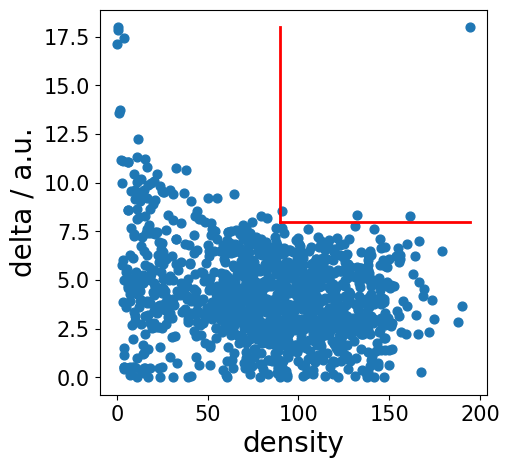

In [11]:
my_clu = MyClustering(df2, pca_array=data_normalized)

# 现在只要调用 dpc(density=..., delta=...) 就能完成聚类
my_clu.dpc(density=90, delta=8)

In [12]:
unique_labels, counts = np.unique(my_clu.df['cluster_label'], return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster label: {label}, Count: {count}")

Cluster label: -1, Count: 59
Cluster label: 0, Count: 143
Cluster label: 1, Count: 12
Cluster label: 2, Count: 911
Cluster label: 3, Count: 56


In [13]:
cluster_labels = my_clu.df['cluster_label']
df2["Cluster_label"] = cluster_labels

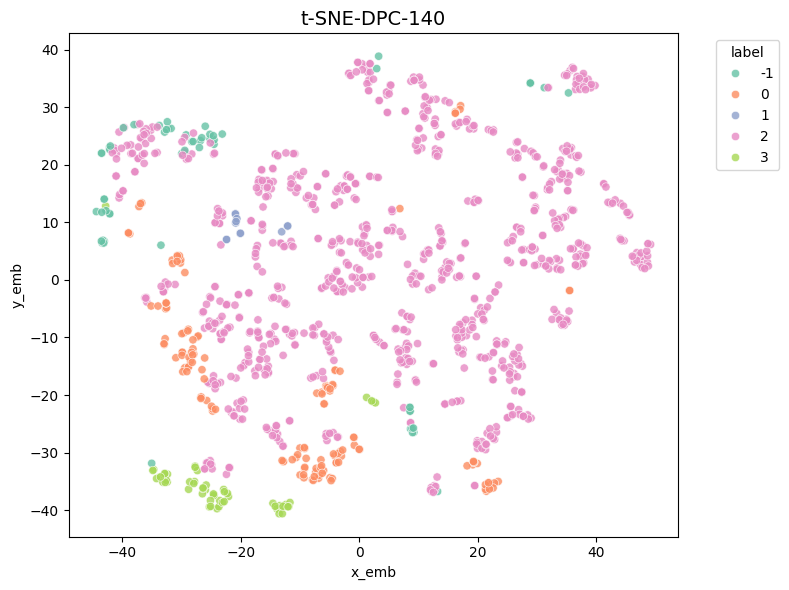

In [14]:
from sklearn.manifold import TSNE

embedding = TSNE(n_components=2).fit_transform(data_normalized)

df2["x_emb"] = embedding[:, 0]
df2["y_emb"] = embedding[:, 1]

# 1. 用 Seaborn 绘制散点图，可视化聚类
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df2,
    x="x_emb",
    y="y_emb",
    hue="Cluster_label",  # 这里按照你聚类的标签着色
    palette="Set2",    # 指定调色板(可换成你喜欢的颜色方案)
    alpha=0.8             # 设置点透明度
)

# 2. 给图添加标题
plt.title("t-SNE-DPC-140", fontsize=14)
plt.legend(title="label", bbox_to_anchor=(1.05, 1), loc="upper left")

# 3. 显示图像
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

# 1. t-SNE 降维
embedding_tsne = TSNE(n_components=2).fit_transform(data_normalized)
df2["x_emb_tsne"] = embedding_tsne[:, 0]
df2["y_emb_tsne"] = embedding_tsne[:, 1]

# 2. PCA 降维
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(data_normalized)
df2["x_emb_pca"] = embedding_pca[:, 0]
df2["y_emb_pca"] = embedding_pca[:, 1]

# 3. UMAP 降维
umap_model = umap.UMAP(n_components=2)
embedding_umap = umap_model.fit_transform(data_normalized)
df2["x_emb_umap"] = embedding_umap[:, 0]
df2["y_emb_umap"] = embedding_umap[:, 1]

# 4. 创建图形和子图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# t-SNE 可视化
sns.scatterplot(
    data=df2,
    x="x_emb_tsne",
    y="y_emb_tsne",
    hue="Cluster_label",
    palette="viridis",
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("t-SNE-DPC-140", fontsize=14)
axes[0].legend(title="label", bbox_to_anchor=(1.05, 1), loc="upper left")

# PCA 可视化
sns.scatterplot(
    data=df2,
    x="x_emb_pca",
    y="y_emb_pca",
    hue="Cluster_label",
    palette="viridis",
    alpha=0.8,
    ax=axes[1]
)
axes[1].set_title("PCA-DPC-140", fontsize=14)
axes[1].legend(title="label", bbox_to_anchor=(1.05, 1), loc="upper left")

# UMAP 可视化
sns.scatterplot(
    data=df2,
    x="x_emb_umap",
    y="y_emb_umap",
    hue="Cluster_label",
    palette="viridis",
    alpha=0.8,
    ax=axes[2]
)
axes[2].set_title("UMAP-DPC-140", fontsize=14)
axes[2].legend(title="label", bbox_to_anchor=(1.05, 1), loc="upper left")

# 调整布局以避免标签重叠
plt.tight_layout()
plt.show()


AttributeError: module 'umap' has no attribute 'UMAP'

In [21]:
!pip uninstall umap -y


Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1


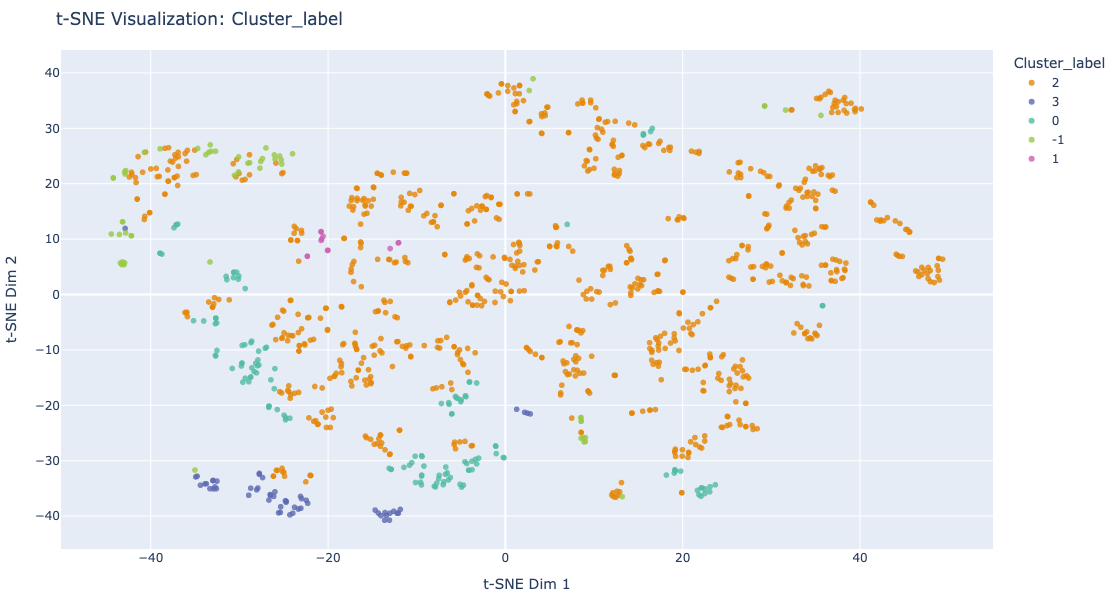

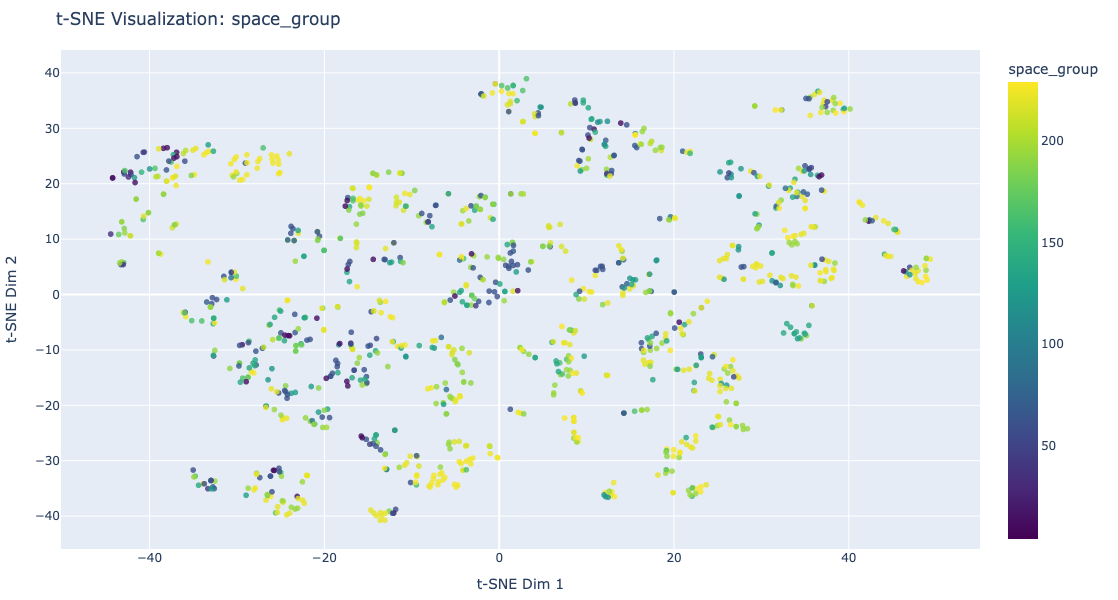

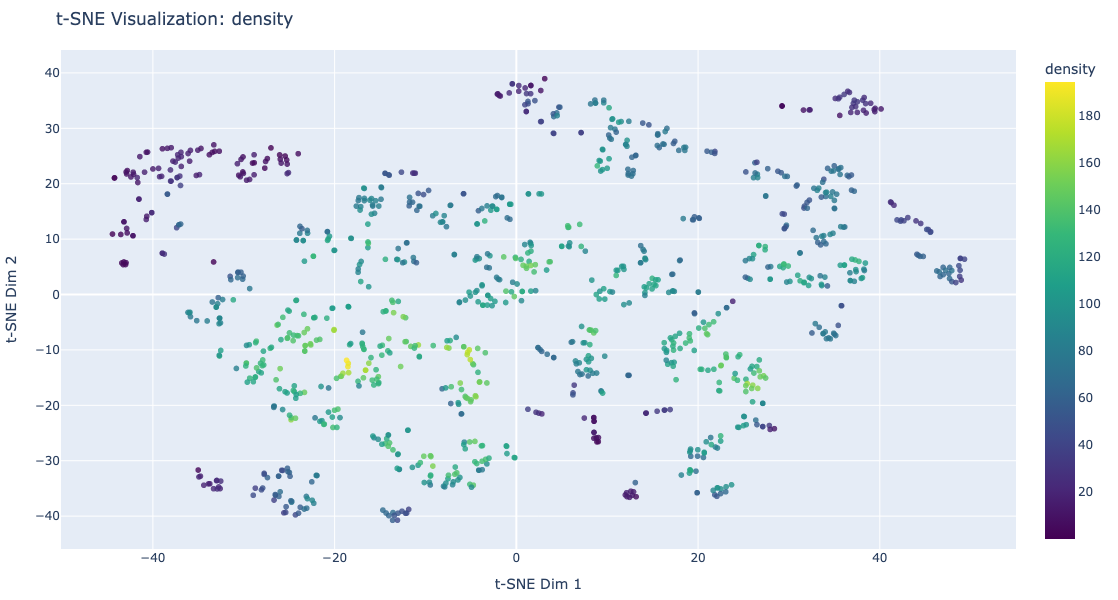

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# 1. 计算 t-SNE 嵌入
embedding = TSNE(n_components=2, random_state=42).fit_transform(data_normalized)

# 2. 将 t-SNE 结果添加到 DataFrame
df2["x_emb"] = embedding[:, 0]
df2["y_emb"] = embedding[:, 1]

# 强制将 Cluster_label 转换为字符串，以确保使用离散颜色
df2["Cluster_label"] = df2["Cluster_label"].astype(str)

# 3. 使用 Plotly 实现交互式可视化
def plot_interactive(df, color_feature, hover_features=["space_group", "density"]):
    """
    Function to create an interactive scatter plot.
    
    Parameters:
    - df: DataFrame with t-SNE results and clustering/space_group/density labels.
    - color_feature: Feature name to use as color coding (e.g., Cluster_label, space_group, density).
    - hover_features: List of column names to include in hover info.
    """
    # 强制分类特征使用离散调色板
    is_discrete = df[color_feature].dtype == 'object'

    fig = px.scatter(
        df,
        x="x_emb",
        y="y_emb",
        color=color_feature,
        title=f"t-SNE Visualization: {color_feature}",
        labels={"x_emb": "t-SNE Dim 1", "y_emb": "t-SNE Dim 2"},
        color_discrete_sequence=px.colors.qualitative.Vivid if is_discrete else None,
        color_continuous_scale="Viridis" if not is_discrete else None,
        opacity=0.8,
        hover_data=hover_features  # Add specified hover info
    )
    fig.update_layout(
        legend_title=dict(text=color_feature),
        legend=dict(orientation="v", x=1.02, y=1, bgcolor="rgba(255,255,255,0.5)"),
        margin=dict(l=50, r=10, t=50, b=10),
        width=1000,  # 图的宽度（单位：像素）
        height=600   # 图的高度（单位：像素）
    )
    fig.show()

# 4. 初始可视化（按 Cluster_label 着色，强制使用分类颜色）
plot_interactive(df2, "Cluster_label")

# 5. 可切换到按 space_group 着色
plot_interactive(df2, "space_group")

# 6. 可切换到按 density 着色（梯度颜色）
plot_interactive(df2, "density")


In [ ]:
from sklearn.metrics import jaccard_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设已经计算好了 HDBSCAN 和 DPC 的离群点
df1["cluster_label"] = df1["cluster_label"].astype(int)
outliers_hdbscan = df1[df1["cluster_label"] == -1]  # 使用 df1 作为 HDBSCAN 的数据源
outliers_dpc = my_clu.df[my_clu.df["cluster_label"] == -1]  # 使用 my_clu.df 作为 DPC 的数据源

# Jaccard Index for outliers
# 这里只计算离群点的 Jaccard 相似度，假设我们比较的是离群点的行数
intersection = set(outliers_hdbscan.index).intersection(set(outliers_dpc.index))
union = set(outliers_hdbscan.index).union(set(outliers_dpc.index))

if len(union) == 0:
    jaccard_similarity = 1.0  # If the union is empty, consider them identical
else:
    jaccard_similarity = len(intersection) / len(union)

print(f"Jaccard index for outliers: {jaccard_similarity}")
print(f"Number of common outliers: {len(intersection)}")
print(f"Number of outliers in HDBSCAN: {len(outliers_hdbscan)}")
print(f"Number of outliers in DPC: {len(outliers_dpc)}")

# Now handle normal clusters (non-outliers) for each clustering algorithm
def get_cluster_indices(clusters_df, cluster_label_column):
    cluster_labels = clusters_df[cluster_label_column].unique()
    cluster_indices = {}
    for label in cluster_labels:
        indices = clusters_df[clusters_df[cluster_label_column] == label].index
        cluster_indices[label] = set(indices)
    return cluster_indices

# 提取 HDBSCAN 和 DPC 的正常簇
clusters_hdbscan = df1[df1["cluster_label"] != -1]
clusters_dpc = my_clu.df[my_clu.df["cluster_label"] != -1]

# Get indices for each cluster
cluster_indices_hdbscan = get_cluster_indices(clusters_hdbscan, "cluster_label")
cluster_indices_dpc = get_cluster_indices(clusters_dpc, "cluster_label")

# Calculate Jaccard similarity matrix for clusters
similarity_matrix = pd.DataFrame(index=cluster_indices_hdbscan.keys(), columns=cluster_indices_dpc.keys())

for label_h in cluster_indices_hdbscan:
    for label_d in cluster_indices_dpc:
        indices_h = cluster_indices_hdbscan[label_h]
        indices_d = cluster_indices_dpc[label_d]
        
        intersection = indices_h.intersection(indices_d)
        union = indices_h.union(indices_d)
        
        if len(union) == 0:
            jaccard_similarity = 1.0
        else:
            jaccard_similarity = len(intersection) / len(union)
        
        similarity_matrix.loc[label_h, label_d] = jaccard_similarity

print("Jaccard similarity matrix for clusters:")
print(similarity_matrix)

# Find the most similar DPC cluster for each HDBSCAN cluster
best_matches_h_to_d = {}
for label_h in cluster_indices_hdbscan:
    best_match = similarity_matrix.loc[label_h].astype(float).idxmax()
    best_similarity = similarity_matrix.loc[label_h].astype(float).max()
    best_matches_h_to_d[label_h] = (best_match, best_similarity)

print("\nThe most similar DPC cluster for each HDBSCAN cluster:")
for label_h, (best_match, best_similarity) in best_matches_h_to_d.items():
    print(f"HDBSCAN cluster {label_h} has the most similar DPC cluster {best_match}, with a Jaccard similarity of {best_similarity}")

# Find the most similar HDBSCAN cluster for each DPC cluster
best_matches_d_to_h = {}
for label_d in cluster_indices_dpc:
    best_match = similarity_matrix[label_d].astype(float).idxmax()
    best_similarity = similarity_matrix[label_d].astype(float).max()
    best_matches_d_to_h[label_d] = (best_match, best_similarity)

print("\nThe most similar HDBSCAN cluster for each DPC cluster:")
for label_d, (best_match, best_similarity) in best_matches_d_to_h.items():
    print(f"DPC cluster {label_d} has the most similar HDBSCAN cluster {best_match}, with a Jaccard similarity of {best_similarity}")


Jaccard index for outliers: 0.37341772151898733
Number of common outliers: 59
Number of outliers in HDBSCAN: 158
Number of outliers in DPC: 59
Jaccard similarity matrix for clusters:
          2         3         0         1
1  0.722727  0.041041  0.137235  0.012195
2  0.024149       0.0       0.0       0.0
0  0.018661       0.0       0.0       0.0

The most similar DPC cluster for each HDBSCAN cluster:
HDBSCAN cluster 1 has the most similar DPC cluster 2, with a Jaccard similarity of 0.7227272727272728
HDBSCAN cluster 2 has the most similar DPC cluster 2, with a Jaccard similarity of 0.024149286498353458
HDBSCAN cluster 0 has the most similar DPC cluster 2, with a Jaccard similarity of 0.018660812294182216

The most similar HDBSCAN cluster for each DPC cluster:
DPC cluster 2 has the most similar HDBSCAN cluster 1, with a Jaccard similarity of 0.7227272727272728
DPC cluster 3 has the most similar HDBSCAN cluster 1, with a Jaccard similarity of 0.04104104104104104
DPC cluster 0 has the 